In [ ]:
!pip install datasets
!pip install openprompt
from datasets import load_dataset, Dataset
from openprompt.plms import load_plm
from openprompt.prompts import MixedTemplate, SoftVerbalizer, ManualVerbalizer
from openprompt.data_utils import InputExample
from openprompt import PromptDataLoader, PromptForClassification
from transformers import  AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
rawdata = load_dataset("csv", data_files={'train': ["/content/drive/MyDrive/data/corpus_train.csv"], 
                                       'validation': ["/content/drive/MyDrive/data/corpus_valid.csv"], 
                                       "test": ["/content/drive/MyDrive/data/corpus_test.csv"]})

Using custom data configuration default-2d5a24ab65228748


Mounted at /content/drive


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2d5a24ab65228748/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# load the plm
plm, tokenizer, model_config, WrapperClass = load_plm("t5", "t5-base")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
rawdata['train']['label']

['assumption',
 'assumption',
 'assumption',
 'testimony',
 'anecdote',
 'assumption',
 'assumption',
 'anecdote',
 'anecdote',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'anecdote',
 'assumption',
 'statistics',
 'assumption',
 'anecdote',
 'title',
 'testimony',
 'assumption',
 'testimony',
 'assumption',
 'assumption',
 'assumption',
 'statistics',
 'assumption',
 'anecdote',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'anecdote',
 'assumption',
 'anecdote',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'anecdote',
 'assumption',
 'assumption',
 'statistics',
 'assumption',
 'testimony',
 'assumption',
 'assumption',
 'assumption',
 'anecdote',
 'anecdote',
 'testimony',
 'assumption',
 'assumption',
 'assumption',
 'assumption',
 'title',
 'assumption',
 'assumption',
 'assumption',
 'statistics',
 '

In [ ]:
rawdata = rawdata.filter(lambda example: example['label']!='title') 
rawdata = rawdata.filter(lambda example: example['label']!='common-ground') 

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
rawdata['train'].shape

(9167, 4)

In [ ]:
# construct a template

#template_text = '{"placeholder": "text_a"} {"soft": "In this sentence, the topic is"} {"mask"} {"soft"}.'
#{"placeholder": "text_a"} {"placeholder": "text_b"} {"soft":"This"} topic {"soft":"is about"} {"mask"}.
#template_text = '{"placeholder":"text_a"} {"soft"} {"soft"} {"soft"} {"soft"} {"mask"}.'
template_text = '{"placeholder":"text_a"} {"soft": None, "duplicate": 20} {"mask"}.'
#template_text = 'In this argumentative text with the title {"meta": "title", "shortenable": False}, the role of this sentence: {"meta": "sentence", "shortenable": False}, is {"mask"}.'

#template_text = 'In an argumentative text, the role of this sentence: {"placeholder": "text_a"}, is {"mask"}.'
mytemplate = MixedTemplate(model=plm, tokenizer=tokenizer, text=template_text)

In [ ]:
def int_label(label):
    if label == "assumption": return 0
    elif label == "testimony": return 1
    elif label == "anecdote": return 2
    elif label == "statistics": return 3
    #elif label == "title": return 4
    #elif label == "common-ground": return 4
    elif label == "other": return 4

In [ ]:
# convert our raw data to openprompt's form
dataset = {}
for split in ['train', 'validation', 'test']:
    dataset[split] = []
    for data in rawdata[split]:
        #input_example = InputExample(meta={"sentence": data['sentence']}, label = int_label(data['label']), guid=data['article_id'])
        input_example = InputExample(text_a= data['sentence'], label = int_label(data['label']), guid=data['article_id'])
        dataset[split].append(input_example)
print(dataset['train'][0])

{
  "guid": 45,
  "label": 0,
  "meta": {},
  "text_a": "which are obviously bad enough",
  "text_b": "",
  "tgt_text": null
}



In [ ]:
train_dataloader = PromptDataLoader(dataset=dataset["train"], template=mytemplate, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=4,shuffle=True, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")

tokenizing: 9167it [00:10, 844.92it/s]


In [ ]:
myverbalizer = SoftVerbalizer(tokenizer, plm, num_classes=5)

In [ ]:
use_cuda = True
prompt_model = PromptForClassification(plm=plm,template=mytemplate, verbalizer=myverbalizer, freeze_plm=False)
if use_cuda: prompt_model=  prompt_model.cuda()

In [ ]:
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']

# it's always good practice to set no decay to biase and LayerNorm parameters
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# Using different optimizer for prompt parameters and model parameters
optimizer_grouped_parameters2 = [
    {'params': prompt_model.verbalizer.group_parameters_1, "lr":3e-5},
    {'params': prompt_model.verbalizer.group_parameters_2, "lr":3e-4},
]


optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
optimizer2 = AdamW(optimizer_grouped_parameters2)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
for epoch in range(5):
    tot_loss = 0
    for step, inputs in enumerate(train_dataloader):
        if use_cuda:
            inputs = inputs.cuda()
        logits = prompt_model(inputs)
        labels = inputs['label']
        loss = loss_func(logits, labels)
        loss.backward()
        tot_loss += loss.item()
        optimizer1.step()
        optimizer1.zero_grad()
        optimizer2.step()
        optimizer2.zero_grad()
        if step%100 ==0: 
          print("epoch = {}, step = {}, tot_loss/(step+1) = {}".format(epoch, step, tot_loss/(step+1)))

epoch = 0, step = 0, tot_loss/(step+1) = 1.552452802658081
epoch = 0, step = 100, tot_loss/(step+1) = 0.9028285142808857
epoch = 0, step = 200, tot_loss/(step+1) = 0.8774790879505784
epoch = 0, step = 300, tot_loss/(step+1) = 0.7600630947521755
epoch = 0, step = 400, tot_loss/(step+1) = 0.6603365363529942
epoch = 0, step = 500, tot_loss/(step+1) = 0.5786694153853341
epoch = 0, step = 600, tot_loss/(step+1) = 0.5376340738201697
epoch = 0, step = 700, tot_loss/(step+1) = 0.49551012142947987
epoch = 0, step = 800, tot_loss/(step+1) = 0.46067437791462046
epoch = 0, step = 900, tot_loss/(step+1) = 0.4358549500840378
epoch = 0, step = 1000, tot_loss/(step+1) = 0.41863117950431605
epoch = 0, step = 1100, tot_loss/(step+1) = 0.40368923844158866
epoch = 0, step = 1200, tot_loss/(step+1) = 0.3853883214704351
epoch = 0, step = 1300, tot_loss/(step+1) = 0.3691341200962285
epoch = 0, step = 1400, tot_loss/(step+1) = 0.357812613759025
epoch = 0, step = 1500, tot_loss/(step+1) = 0.34765533401694726
e

In [ ]:
# ## evaluate

# %%
validation_dataloader = PromptDataLoader(dataset=dataset["validation"], template=mytemplate, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=4,shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")

prompt_model.eval()

allpreds = []
alllabels = []
for step, inputs in enumerate(validation_dataloader):
    if use_cuda:
        inputs = inputs.cuda()
    logits = prompt_model(inputs)
    labels = inputs['label']
    alllabels.extend(labels.cpu().tolist())
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
print("validation:",acc)

print(classification_report(alllabels, allpreds, zero_division=0))



tokenizing: 2599it [00:03, 837.12it/s]


validation: 0.8476337052712581
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1826
           1       0.77      0.74      0.75       219
           2       0.68      0.68      0.68       458
           3       0.78      0.80      0.79        66
           4       0.41      0.40      0.41        30

    accuracy                           0.85      2599
   macro avg       0.71      0.71      0.71      2599
weighted avg       0.85      0.85      0.85      2599



In [ ]:
#validation:
test_dataloader = PromptDataLoader(dataset=dataset["test"], template=mytemplate, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=4,shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")
allpreds = []
alllabels = []
for step, inputs in enumerate(test_dataloader):
    if use_cuda:
        inputs = inputs.cuda()
    logits = prompt_model(inputs)
    labels = inputs['label']
    alllabels.extend(labels.cpu().tolist())
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
print("test:", acc)  # roughly ~0.85
print(classification_report(alllabels, allpreds, zero_division=0))

tokenizing: 1315it [00:01, 819.35it/s]


test: 0.8577946768060837
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       877
           1       0.82      0.78      0.80       119
           2       0.76      0.69      0.72       269
           3       0.94      0.79      0.86        38
           4       0.38      0.50      0.43        12

    accuracy                           0.86      1315
   macro avg       0.76      0.74      0.74      1315
weighted avg       0.86      0.86      0.86      1315



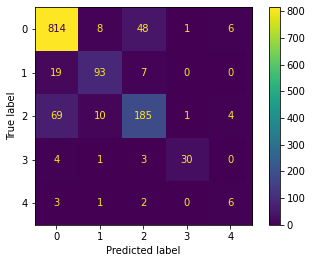

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(alllabels, allpreds))
disp.plot()
plt.show()

In [ ]:
rawcmv = load_dataset("csv", data_files={'CMV': ["/content/drive/MyDrive/data/cmv_train.csv"]})
cmvdata = []
for data in rawcmv['CMV']:
    input_example = InputExample(text_a= data['sentence'], label = int_label(data['label']))
    cmvdata.append(input_example)
print(cmvdata[0])

Using custom data configuration default-281a303eac496458
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-281a303eac496458/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

{
  "guid": null,
  "label": 0,
  "meta": {},
  "text_a": "Where there isn't a governed region, someone will find a way to control the people in the region through use of violence.",
  "text_b": "",
  "tgt_text": null
}



In [ ]:
#test on CMV data:
cmv_dataloader = PromptDataLoader(dataset= cmvdata, template=mytemplate, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
    batch_size=4,shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="head")
allpreds = []
alllabels = []
for step, inputs in enumerate(cmv_dataloader):
    if use_cuda:
        inputs = inputs.cuda()
    logits = prompt_model(inputs)
    labels = inputs['label']
    alllabels.extend(labels.cpu().tolist())
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
print("test:", acc)  # roughly ~0.85
print(classification_report(alllabels, allpreds, zero_division=0))

tokenizing: 2030it [00:02, 840.13it/s]


test: 0.8428571428571429
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1716
           1       0.04      0.10      0.06        20
           2       0.57      0.35      0.43       222
           3       0.53      0.20      0.29        49
           4       0.04      0.04      0.04        23

    accuracy                           0.84      2030
   macro avg       0.42      0.33      0.35      2030
weighted avg       0.84      0.84      0.84      2030



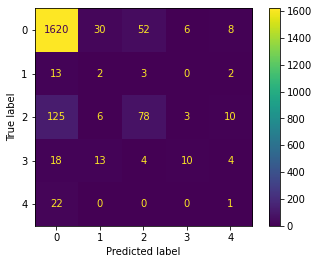

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(alllabels, allpreds))
disp.plot()
plt.show()